In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_json("DATASET/train.json")
test_df = pd.read_json("DATASET/test.json")

train_df.columns = ["label","image_path"]
test_df.columns = ["label","image_path"]

train_df.head(5)

,label,image_path
0,1,train/353042_4-IMG005x014-1.JPG
1,1,train/353042_4-IMG005x015-1.JPG
2,1,train/353042_4-IMG006x010-1.JPG
3,1,train/353042_4-IMG007x011-1.JPG
4,1,train/353042_4-IMG007x015-1.JPG


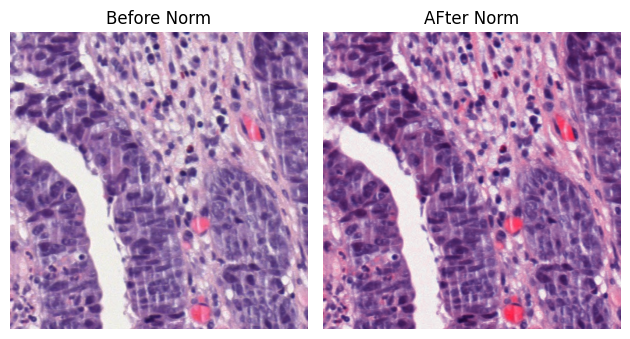

In [3]:
import torchstain
import numpy as np
from PIL import Image

# read target
target = np.array(Image.open("DATASET/train/543716-IMG013x011-2.JPG"))
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
normalizer.fit(target)


# normalize image
img = np.array(Image.open("DATASET/train/543716-IMG014x012-2.JPG"))
norm, H, E = normalizer.normalize(img)

plt.subplot(121)
plt.title("Before Norm")
plt.imshow(img)
plt.axis("off")

plt.subplot(122)
plt.imshow(norm)
plt.axis("off")
plt.title("AFter Norm")

plt.tight_layout()
plt.show()

In [5]:
import torchstain
import numpy as np
from PIL import Image
import os

def normalize(target_image, df, out_root):

    target = np.array(Image.open(target_image))
    normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
    normalizer.fit(target)

    new_paths = []

    for idx in range(len(df)):

        image_path = os.path.join("DATASET/", df.iloc[idx, 1])

        img = np.array(Image.open(image_path))
        norm, H, E = normalizer.normalize(img)

        filename = os.path.basename(image_path)
        save_dir = os.path.join(out_root)
        os.makedirs(save_dir, exist_ok=True)

        save_path = os.path.join(save_dir, filename)
        Image.fromarray(norm).save(save_path)
        new_paths.append(save_path)

    df["stain_normalized_path"] = new_paths

target_image = "DATASET/train/543716-IMG013x011-2.JPG"
normalize(target_image,train_df,"DATASET_STAIN_NORMALIZED/train")
normalize(target_image, test_df,"DATASET_STAIN_NORMALIZED/test")


In [6]:
train_df.to_csv("DATASET_STAIN_NORMALIZED/train.csv")
test_df.to_csv("DATASET_STAIN_NORMALIZED/test.csv")

In [7]:
train_df

,label,image_path,stain_normalized_path
0,1,train/353042_4-IMG005x014-1.JPG,DATASET_STAIN_NORMALIZED/train/353042_4-IMG005...
1,1,train/353042_4-IMG005x015-1.JPG,DATASET_STAIN_NORMALIZED/train/353042_4-IMG005...
2,1,train/353042_4-IMG006x010-1.JPG,DATASET_STAIN_NORMALIZED/train/353042_4-IMG006...
3,1,train/353042_4-IMG007x011-1.JPG,DATASET_STAIN_NORMALIZED/train/353042_4-IMG007...
4,1,train/353042_4-IMG007x015-1.JPG,DATASET_STAIN_NORMALIZED/train/353042_4-IMG007...
...,...,...,...
4016,2,train/543716-IMG017x010-2.JPG,DATASET_STAIN_NORMALIZED/train/543716-IMG017x0...
4017,2,train/543716-IMG017x011-2.JPG,DATASET_STAIN_NORMALIZED/train/543716-IMG017x0...
4018,2,train/543716-IMG017x012-2.JPG,DATASET_STAIN_NORMALIZED/train/543716-IMG017x0...
4019,2,train/543716-IMG017x017-2.JPG,DATASET_STAIN_NORMALIZED/train/543716-IMG017x0...


In [10]:
import cv2
import numpy as np
from PIL import Image

def preprocess(df,out_root):

    new_paths = []

    for idx in range(len(df)):

        image_path = df.iloc[idx, 2]
        img = np.array(Image.open(image_path))

        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = cv2.medianBlur(img, 3)
        img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)
        img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        L2 = clahe.apply(L)

        lab = cv2.merge((L2, A, B))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        filename = os.path.basename(image_path)
        save_dir = os.path.join(out_root)
        os.makedirs(save_dir, exist_ok=True)

        save_path = os.path.join(save_dir, filename)
        Image.fromarray(norm).save(save_path)
        new_paths.append(save_path)

    df["normalized_path"] = new_paths

In [11]:
preprocess(train_df,"DATASET_STAIN_NORMALIZED/train")
preprocess(test_df,"DATASET_STAIN_NORMALIZED/test")

In [12]:
train_df.to_csv("DATASET_STAIN_NORMALIZED/train.csv")
test_df.to_csv("DATASET_STAIN_NORMALIZED/test.csv")

In [13]:
from torchvision import transforms

temp_transform = transforms.Compose([    
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.files[idx].split(".")[0][-1]
        
        if self.transform:
            img = self.transform(img)

        return img,label

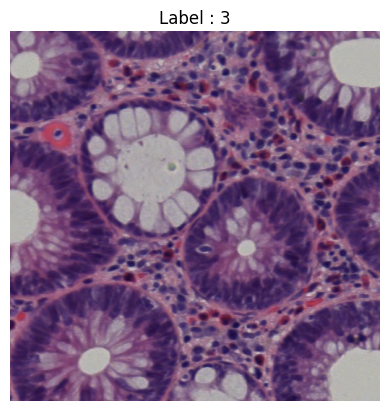

In [16]:
import random

temp_dataloader = MyDataset("DATASET/train")
random_idx = random.randint(0, len(temp_dataloader) - 1)
img, label = temp_dataloader.__getitem__(random_idx)

plt.axis("off")
plt.title(f"Label : {label}")
plt.imshow(img)
plt.show()

In [17]:
def get_mean_std(loader):

    mean = 0
    std = 0
    total_images = 0

    for images,_ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples,images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean.tolist(),std.tolist()

In [18]:
from torch.utils.data import DataLoader

temp_train = MyDataset("DATASET/train",transform=temp_transform)
temp_test = MyDataset("DATASET/test", transform=temp_transform)

temp_train_loader = DataLoader(
    temp_train,
    batch_size=512,
    num_workers=0,
    shuffle=False
)

temp_test_loader = DataLoader(
    temp_test,
    batch_size=512,
    num_workers=0,
    shuffle=False
)

train_mean, train_std = get_mean_std(temp_train_loader)
test_mean, test_std = get_mean_std(temp_test_loader)

print(train_mean, train_std)
print(test_mean,test_std)

[0.6470240950584412, 0.5522786974906921, 0.6694759726524353] [0.16983367502689362, 0.19936919212341309, 0.12838208675384521]
[0.6688644289970398, 0.5761644244194031, 0.6906368136405945] [0.17447151243686676, 0.20483636856079102, 0.13144786655902863]


In [19]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip()
    ],p = 0.7),
    transforms.RandomApply([
        transforms.RandomRotation(50)
    ],p = 0.7),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness = 0.2,
            contrast = 0.2,
            saturation = 0.1,
            hue = 0.05,
        ),
    ], p =0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean,train_std)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(test_mean,test_std)
])

In [20]:
train_dataset = MyDataset("DATASET/train", transform=train_transform)
test_dataset = MyDataset("DATASET/test", transform=train_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

4